# Importare le librerie


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix as sk_confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from google.colab import drive
from PIL import Image
import torchvision.transforms as T

# Mount Google Drive
drive.mount('/content/drive')

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Mounted at /content/drive
Using device: cuda


# Caricare i dati

In [3]:
# Standard transformation (resize, tensor, normalize)
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Augmentation transformations for the target class (for retinitis pigmentosa)
# Three augmented copies will be generated: horizontal flip, rotation and vertical flip.
augmentation_transforms = [
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomRotation(degrees=30),
    transforms.RandomVerticalFlip(p=1.0)
]

# Custom dataset that adds augmented copies for the target class (assumed to be class index 1)
class AugmentedImageFolder(Dataset):
    def __init__(self, root, transform=None, augmentation_transforms=None, target_class=1, num_augmented=3):
        """
        root: folder path (directory structure compatible with ImageFolder)
        transform: standard transformations (e.g., resize, ToTensor, normalize)
        augmentation_transforms: list of transformations to apply for augmented copies
        target_class: index of the class for which to generate augmentations (for retinitis pigmentosa, assume class 1)
        num_augmented: number of augmented copies to generate per target image
        """
        # Load the original dataset without transformations (will be applied manually)
        self.dataset = ImageFolder(root, transform=None)
        self.transform = transform
        self.augmentation_transforms = augmentation_transforms
        self.target_class = target_class
        self.num_augmented = num_augmented

        # Create a new list of samples.
        # Each element is a tuple (img_path, label, aug_id)
        # aug_id is None for the original image, or an integer [0, num_augmented-1] for augmented copies.
        self.samples = []
        for img_path, label in self.dataset.samples:
            # Add the original sample
            self.samples.append((img_path, label, None))
            # If the sample belongs to the target class, add the augmented copies
            if label == self.target_class:
                for aug_id in range(self.num_augmented):
                    self.samples.append((img_path, label, aug_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label, aug_id = self.samples[idx]
        # Load the image (PIL)
        image = self.dataset.loader(img_path)
        # If augmentation is requested, apply the corresponding transformation
        if aug_id is not None and self.augmentation_transforms is not None:
            aug_transform = self.augmentation_transforms[aug_id]
            image = aug_transform(image)
        # Apply standard transformation (resize, tensor, normalize)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

# Dataset paths
train_dir = '/content/drive/MyDrive/Night_Wolves/RPvsControl/data/train'
test_dir  = '/content/drive/MyDrive/Night_Wolves/RPvsControl/data/test'

# Load datasets:
# - For training, use the custom dataset that includes augmentations for the target class (class 1)
# - For testing, use ImageFolder with the standard transformations.
full_dataset = AugmentedImageFolder(train_dir, transform=transform, augmentation_transforms=augmentation_transforms, target_class=1, num_augmented=3)
test_dataset = ImageFolder(test_dir, transform=transform)

print(f"Total number of training images (including augmentations): {len(full_dataset)}")
print(f"Total number of test images: {len(test_dataset)}")

# Extract class names (ensure the order is ['Controllo', 'Retinite Pigmentosa'])
class_names = full_dataset.dataset.classes
print("Classes:", class_names)

# Split the full dataset: 80% for training, 20% for validation
dataset_size = len(full_dataset)
val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size

Total number of training images (including augmentations): 1632
Total number of test images: 258
Classes: ['control', 'retinite']


# Definizione della CNN

In [4]:
# Fixed parameters
batch_size = 32
num_epochs = 20
patience = 5  # Number of epochs without improvement before early stopping

# Define the SimpleCNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # After two pooling layers, from 150x150 we get roughly 150/2/2 ≈ 37
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 37 * 37, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Hyperparameter combinations to test
learning_rates = [0.001, 0.0005]
optimizers_to_try = {
    "Adam": optim.Adam,
    "SGD": lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9)
}


# Addestrare il modello


--- Experiment with Adam and LR = 0.001 ---
Opt: Adam, LR: 0.001, Epoch 1/20 | Train Loss: 0.3363, Acc: 0.8721 | Val Loss: 0.1858, Acc: 0.9325
Opt: Adam, LR: 0.001, Epoch 2/20 | Train Loss: 0.1861, Acc: 0.9265 | Val Loss: 0.1910, Acc: 0.9264
Opt: Adam, LR: 0.001, Epoch 3/20 | Train Loss: 0.1704, Acc: 0.9449 | Val Loss: 0.1656, Acc: 0.9387
Opt: Adam, LR: 0.001, Epoch 4/20 | Train Loss: 0.1499, Acc: 0.9464 | Val Loss: 0.1094, Acc: 0.9632
Opt: Adam, LR: 0.001, Epoch 5/20 | Train Loss: 0.1286, Acc: 0.9533 | Val Loss: 0.1091, Acc: 0.9663
Opt: Adam, LR: 0.001, Epoch 6/20 | Train Loss: 0.1118, Acc: 0.9602 | Val Loss: 0.1372, Acc: 0.9540
Opt: Adam, LR: 0.001, Epoch 7/20 | Train Loss: 0.1129, Acc: 0.9632 | Val Loss: 0.1251, Acc: 0.9509
Opt: Adam, LR: 0.001, Epoch 8/20 | Train Loss: 0.1149, Acc: 0.9617 | Val Loss: 0.0805, Acc: 0.9755
Opt: Adam, LR: 0.001, Epoch 9/20 | Train Loss: 0.0823, Acc: 0.9740 | Val Loss: 0.3297, Acc: 0.9018
Opt: Adam, LR: 0.001, Epoch 10/20 | Train Loss: 0.1162, Acc: 0.9

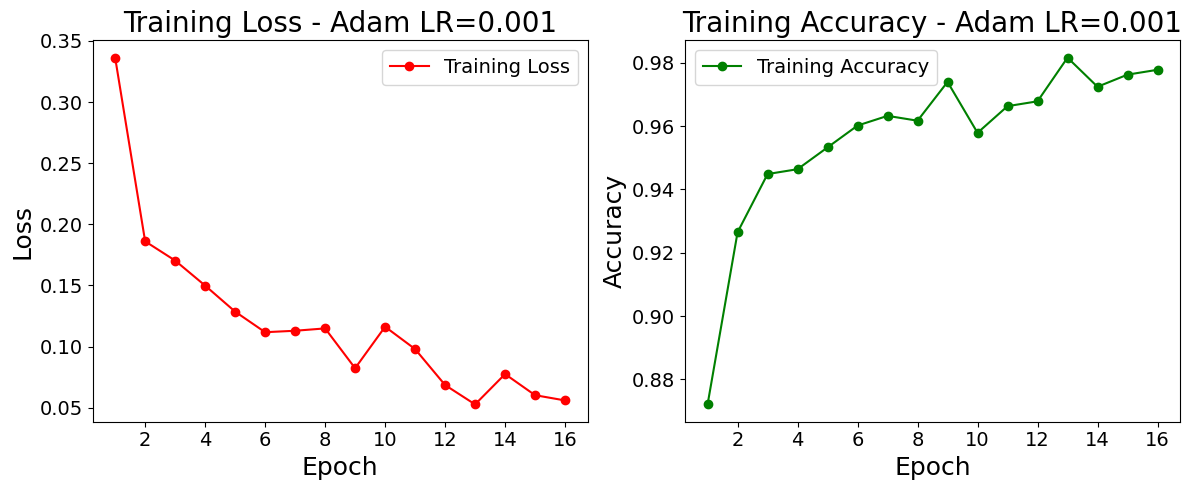

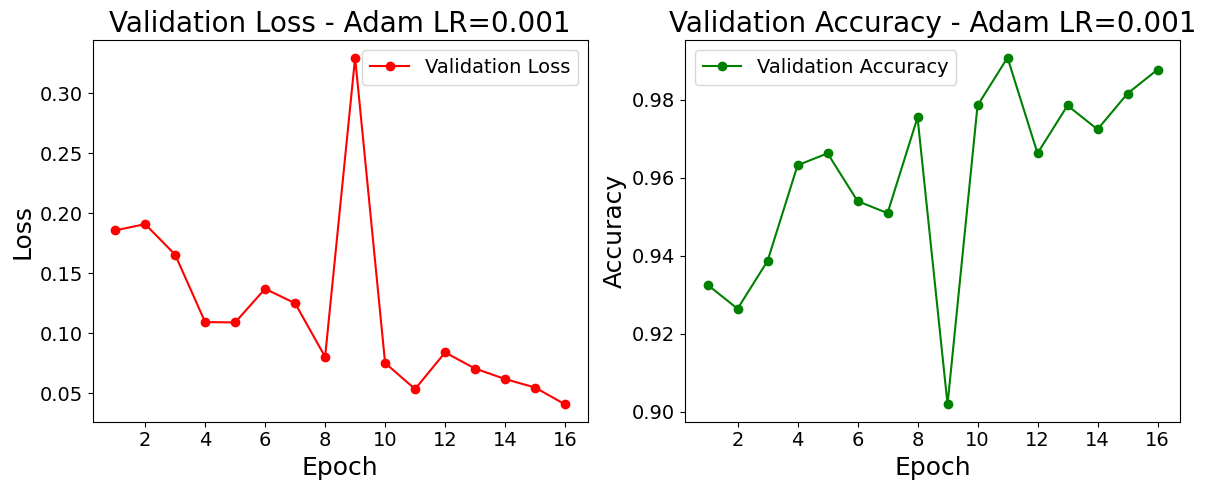

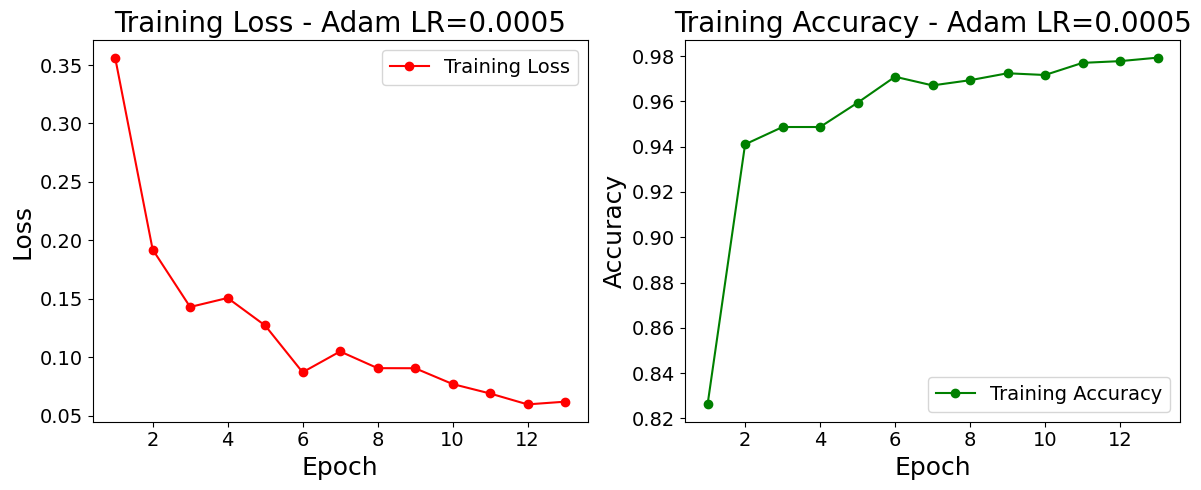

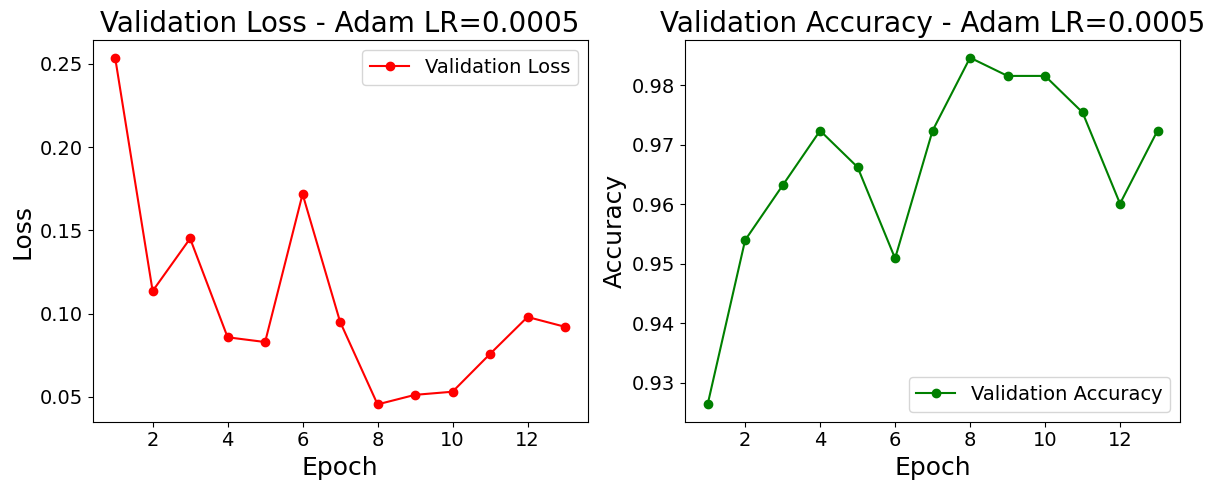

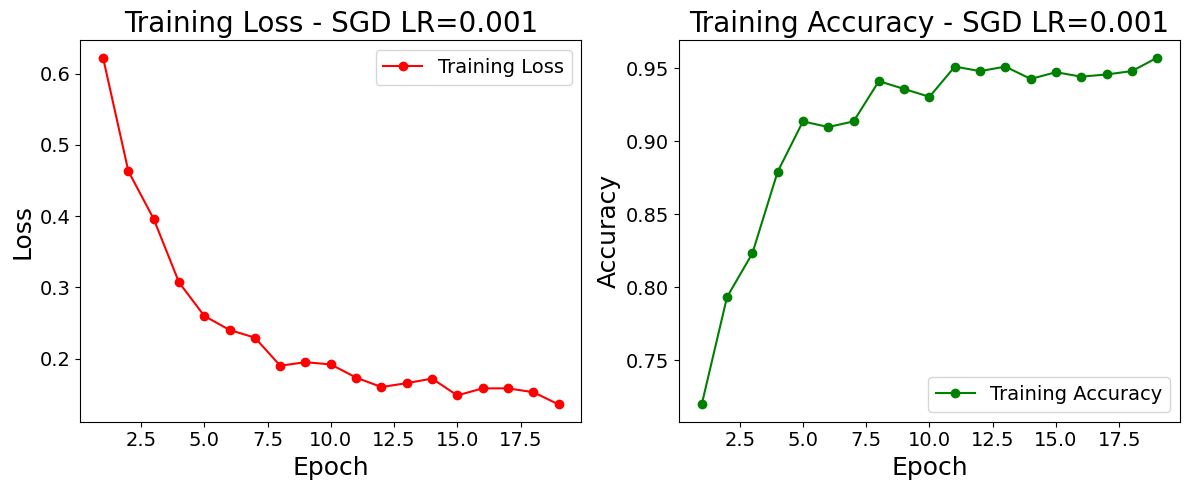

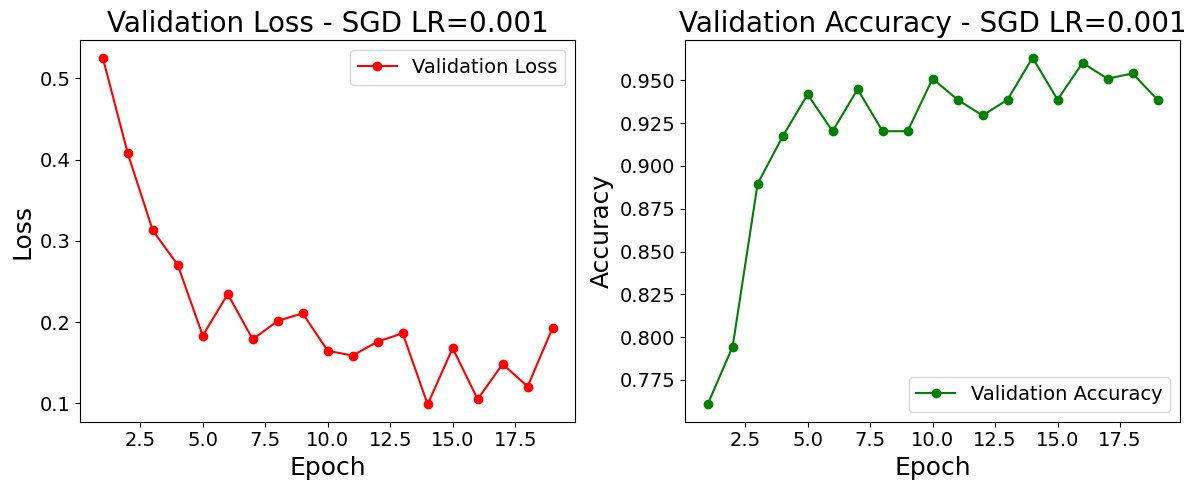

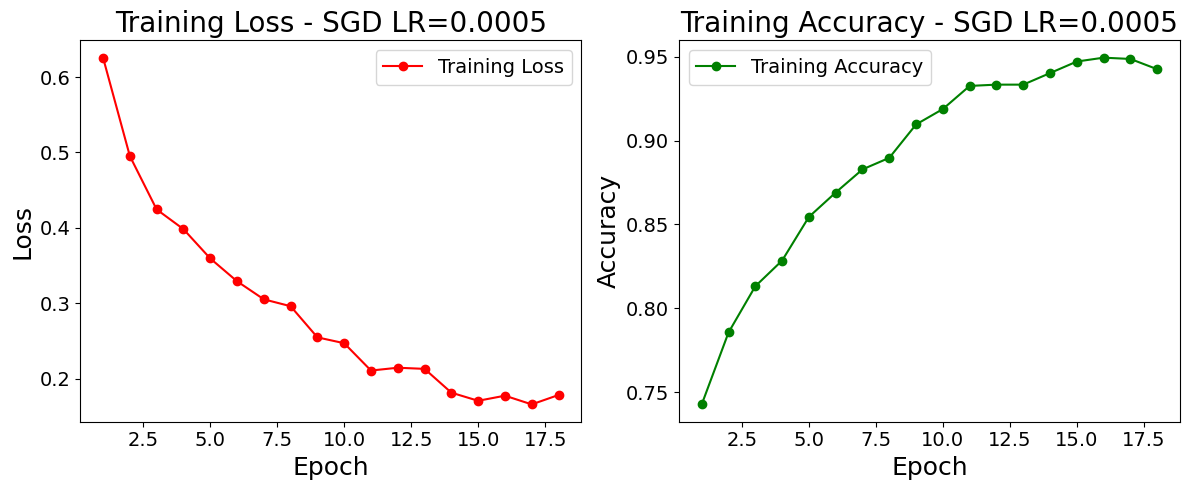

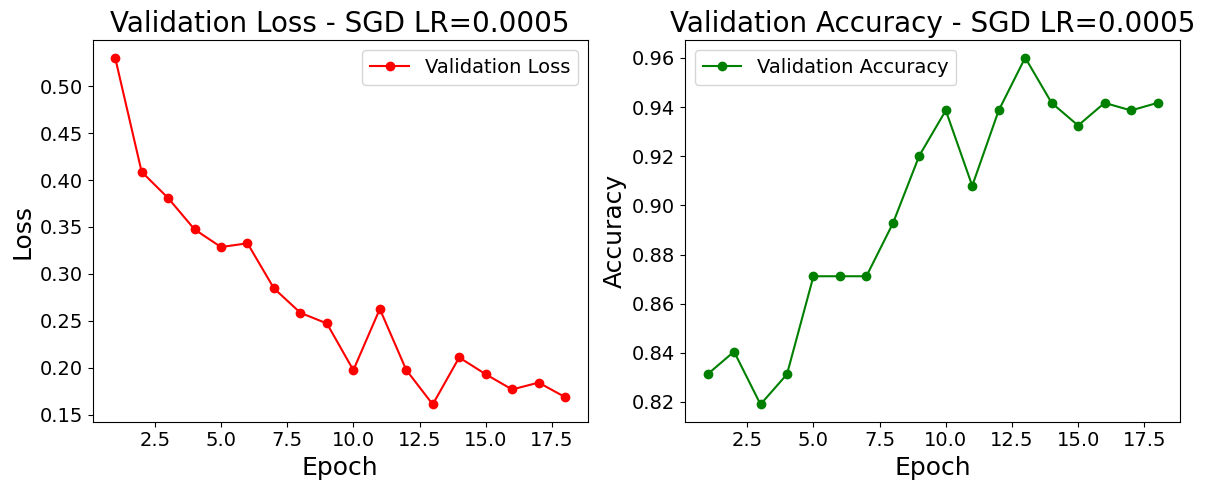

Saved model: model_Adam_LR0.001.pt
Saved model: model_Adam_LR0.0005.pt
Saved model: model_SGD_LR0.001.pt
Saved model: model_SGD_LR0.0005.pt


In [5]:
# Function to run training and validation for a given hyperparameter combination.
def run_experiment(optimizer_constructor, lr):
    # Create a new model for this combination
    model = SimpleCNN().to(device)
    optimizer = optimizer_constructor(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    best_val_acc = 0.0
    best_model_state = None
    trigger_times = 0

    # To record metrics for plotting
    exp_train_acc = []
    exp_val_acc = []
    exp_train_loss = []
    exp_val_loss = []

    # Training loop with a random split at each epoch
    for epoch in range(num_epochs):
        # New random split at each epoch
        train_subset, val_subset = random_split(full_dataset, [train_size, val_size])
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=True)

        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / total_train
        train_acc = correct_train / total_train
        exp_train_loss.append(train_loss)
        exp_train_acc.append(train_acc)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.float().to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                preds = (outputs > 0.5).float()
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
        val_loss = running_val_loss / total_val
        val_acc = correct_val / total_val
        exp_val_loss.append(val_loss)
        exp_val_acc.append(val_acc)

        print(f"Opt: {optimizer_constructor.__name__ if hasattr(optimizer_constructor, '__name__') else 'SGD'}, LR: {lr}, Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        # Early stopping: if validation accuracy does not improve for 'patience' epochs, stop.
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping triggered.")
                break

    return best_val_acc, best_model_state, exp_train_loss, exp_train_acc, exp_val_loss, exp_val_acc

# Run experiments for all hyperparameter combinations.
experiment_results = {}  # key: (optimizer_name, lr)
for opt_name, opt_constructor in optimizers_to_try.items():
    for lr in learning_rates:
        print(f"\n--- Experiment with {opt_name} and LR = {lr} ---")
        best_val_acc, best_state, train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = run_experiment(opt_constructor, lr)
        experiment_results[(opt_name, lr)] = {
            'best_val_acc': best_val_acc,
            'best_state': best_state,
            'train_loss': train_loss_hist,
            'train_acc': train_acc_hist,
            'val_loss': val_loss_hist,
            'val_acc': val_acc_hist
        }

# Plot training and validation metrics for each hyperparameter combination with large labels.
for (opt_name, lr), result in experiment_results.items():
    epochs = list(range(1, len(result['train_loss']) + 1))

    # Plot training metrics (Loss and Accuracy)
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(epochs, result['train_loss'], marker='o', label='Training Loss', color='red')
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.title(f'Training Loss - {opt_name} LR={lr}', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)

    plt.subplot(1,2,2)
    plt.plot(epochs, result['train_acc'], marker='o', label='Training Accuracy', color='green')
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.title(f'Training Accuracy - {opt_name} LR={lr}', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

    # Plot validation metrics (Loss and Accuracy)
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(epochs, result['val_loss'], marker='o', label='Validation Loss', color='red')
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.title(f'Validation Loss - {opt_name} LR={lr}', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)

    plt.subplot(1,2,2)
    plt.plot(epochs, result['val_acc'], marker='o', label='Validation Accuracy', color='green')
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.title(f'Validation Accuracy - {opt_name} LR={lr}', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

# Save all four models and prepare for testing on the test set.
for (opt_name, lr), result in experiment_results.items():
    filename = f"model_{opt_name}_LR{lr}.pt"
    torch.save(result['best_state'], filename)
    print(f"Saved model: {filename}")

# Valutazione del modello


Test Accuracy for Adam LR=0.001: 94.96%


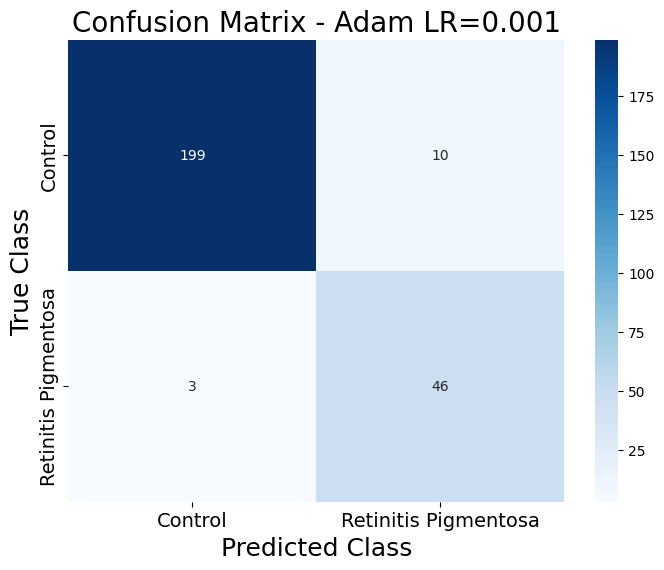

Classification Report for Adam LR=0.001:
                      precision    recall  f1-score   support

             Control       0.99      0.95      0.97       209
Retinitis Pigmentosa       0.82      0.94      0.88        49

            accuracy                           0.95       258
           macro avg       0.90      0.95      0.92       258
        weighted avg       0.95      0.95      0.95       258



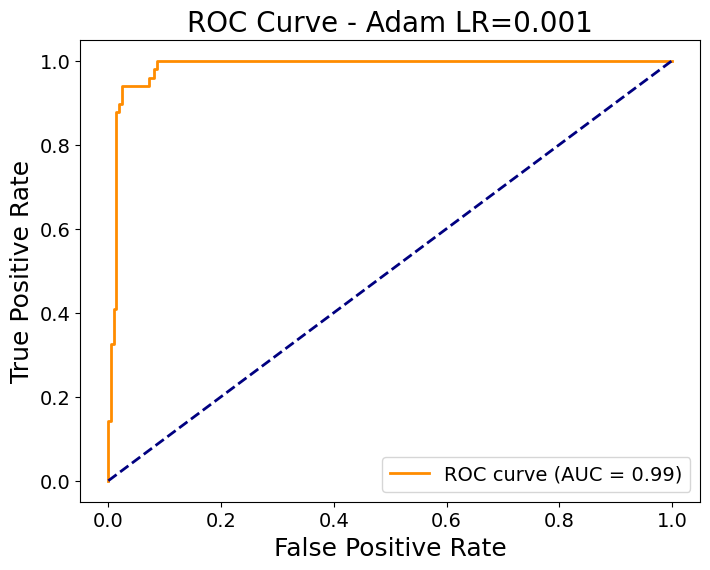

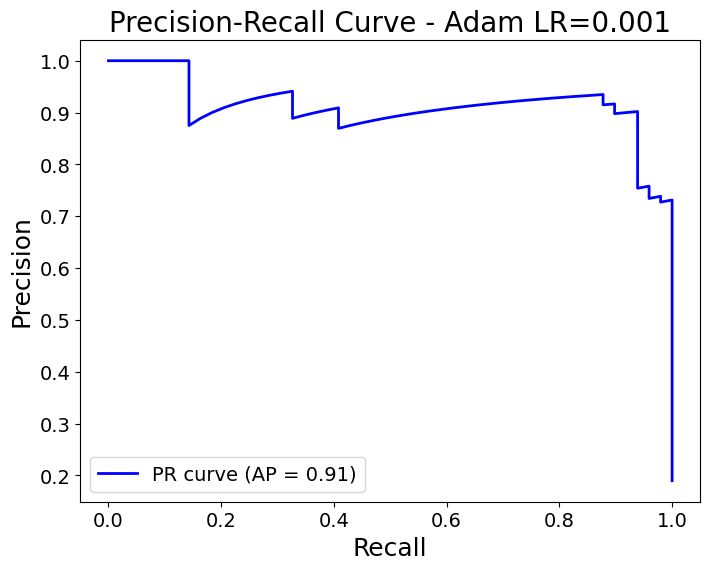


Test Accuracy for Adam LR=0.0005: 96.51%


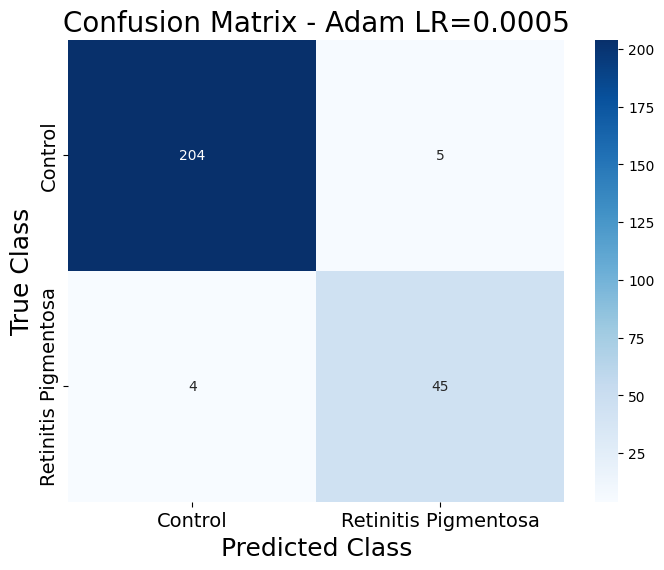

Classification Report for Adam LR=0.0005:
                      precision    recall  f1-score   support

             Control       0.98      0.98      0.98       209
Retinitis Pigmentosa       0.90      0.92      0.91        49

            accuracy                           0.97       258
           macro avg       0.94      0.95      0.94       258
        weighted avg       0.97      0.97      0.97       258



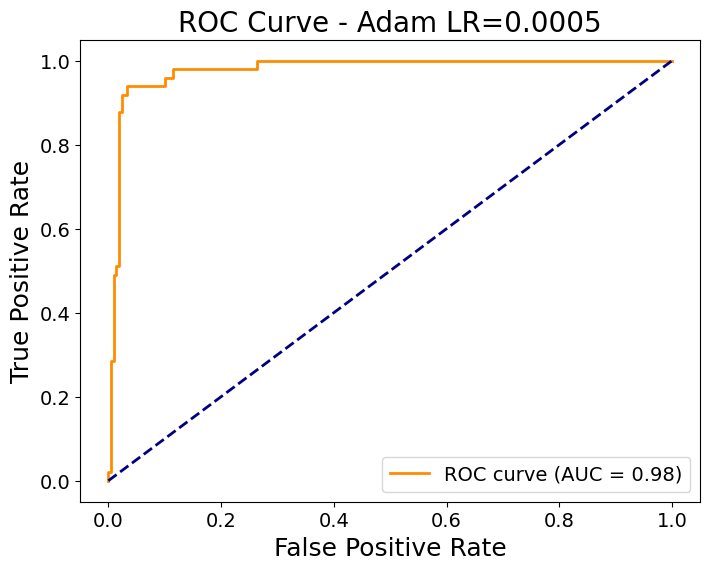

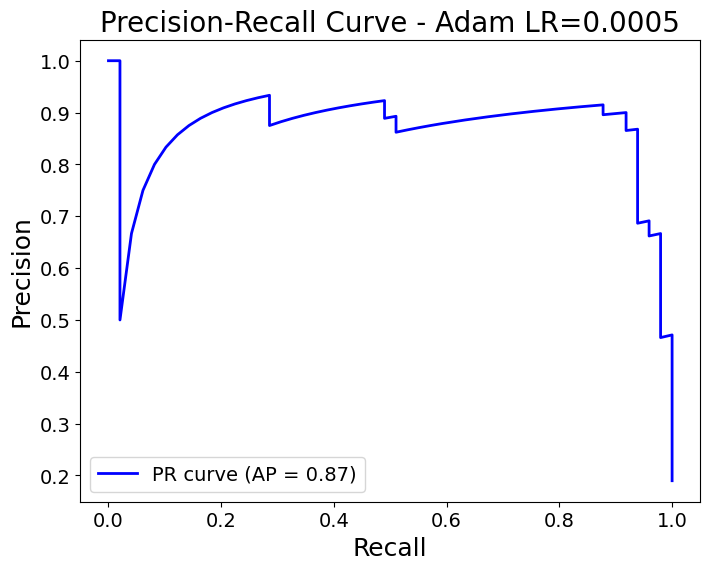


Test Accuracy for SGD LR=0.001: 91.09%


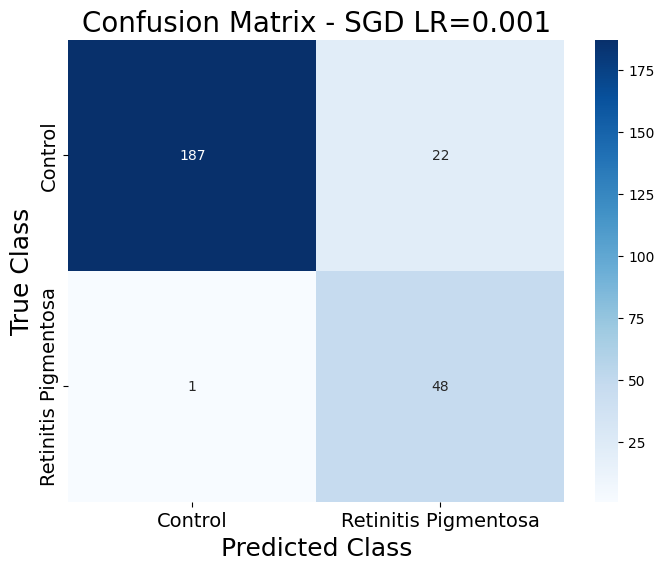

Classification Report for SGD LR=0.001:
                      precision    recall  f1-score   support

             Control       0.99      0.89      0.94       209
Retinitis Pigmentosa       0.69      0.98      0.81        49

            accuracy                           0.91       258
           macro avg       0.84      0.94      0.87       258
        weighted avg       0.94      0.91      0.92       258



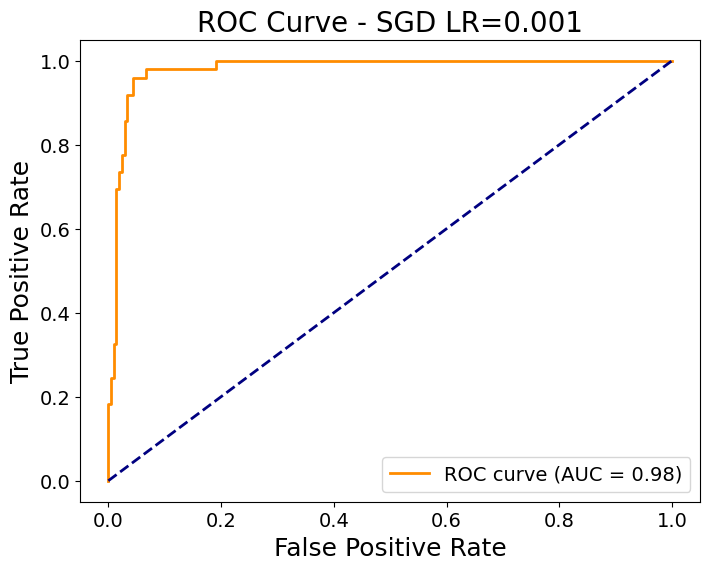

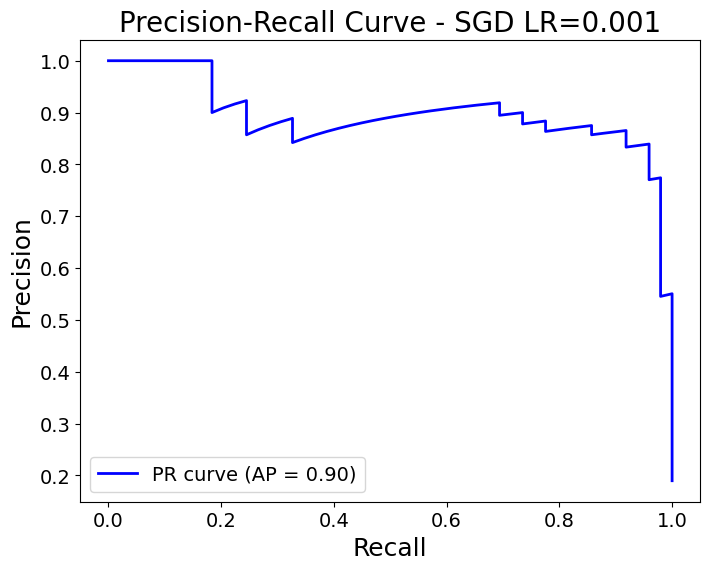


Test Accuracy for SGD LR=0.0005: 93.80%


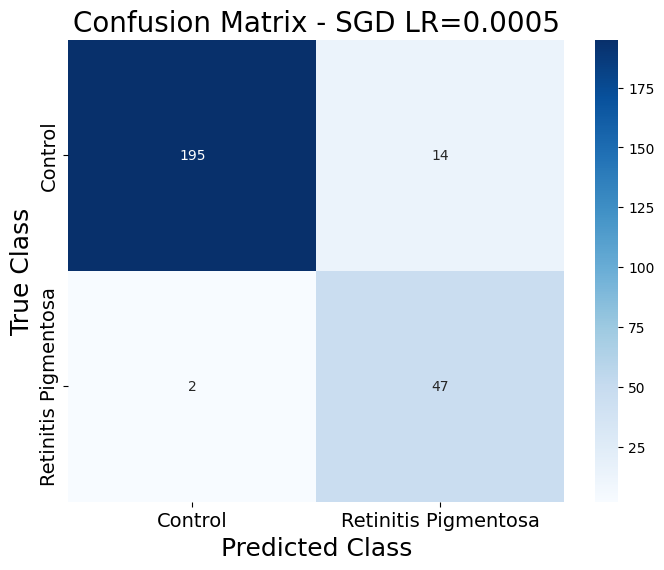

Classification Report for SGD LR=0.0005:
                      precision    recall  f1-score   support

             Control       0.99      0.93      0.96       209
Retinitis Pigmentosa       0.77      0.96      0.85        49

            accuracy                           0.94       258
           macro avg       0.88      0.95      0.91       258
        weighted avg       0.95      0.94      0.94       258



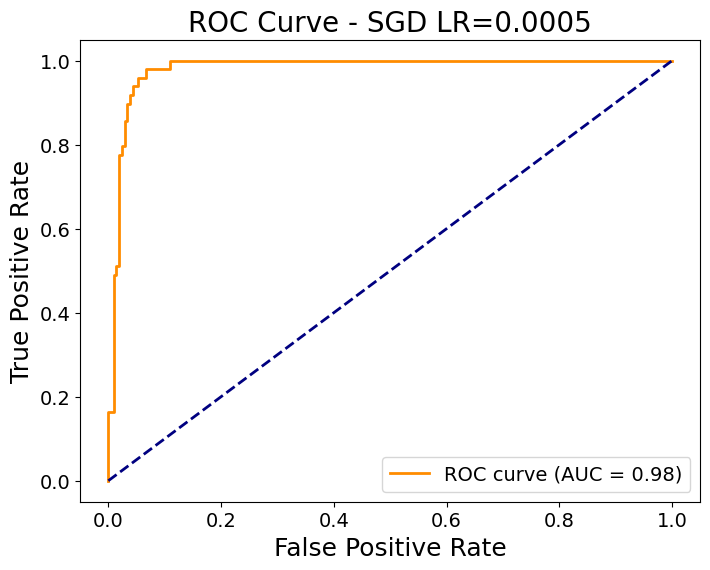

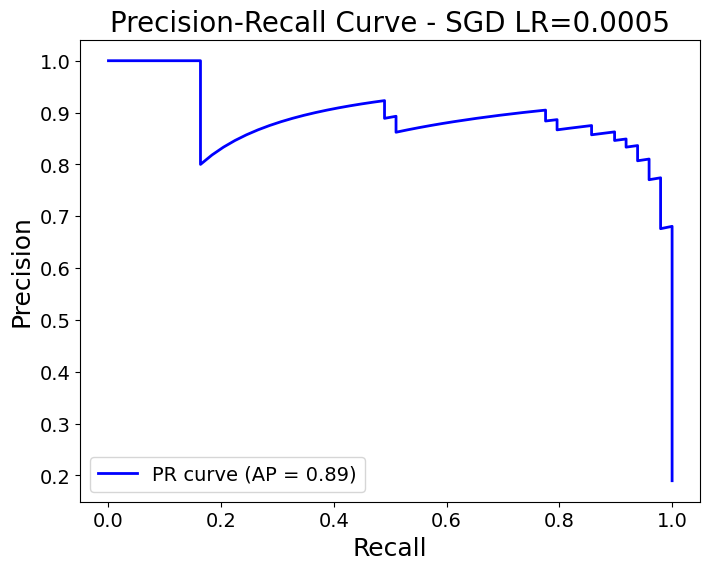

In [8]:
# Define a function to evaluate a model and plot various metrics on the test set.
def evaluate_and_plot_metrics(model, test_loader, class_names, model_label):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  # To store the raw output probabilities

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            probs = outputs.cpu().numpy()  # probabilities from sigmoid
            preds = (outputs > 0.5).float().cpu().numpy()
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # Compute overall test accuracy
    correct = np.sum(np.array(all_preds) == np.array(all_labels))
    total = len(all_labels)
    test_acc = 100 * correct / total
    print(f"\nTest Accuracy for {model_label}: {test_acc:.2f}%")

    # Confusion Matrix
    cm = sk_confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_label}', fontsize=20)
    plt.xlabel('Predicted Class', fontsize=18)
    plt.ylabel('True Class', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    # Classification Report
    print(f"Classification Report for {model_label}:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:0.2f})')
    plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title(f'ROC Curve - {model_label}', fontsize=20)
    plt.legend(loc="lower right", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    ap_score = average_precision_score(all_labels, all_probs)
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {ap_score:0.2f})')
    plt.xlabel('Recall', fontsize=18)
    plt.ylabel('Precision', fontsize=18)
    plt.title(f'Precision-Recall Curve - {model_label}', fontsize=20)
    plt.legend(loc="lower left", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

# Create the test DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate all 4 saved models on the test set.
for (opt_name, lr), result in experiment_results.items():
    model_instance = SimpleCNN().to(device)
    model_instance.load_state_dict(result['best_state'])
    model_label = f"{opt_name} LR={lr}"
    evaluate_and_plot_metrics(model_instance, test_loader, ['Control', 'Retinitis Pigmentosa'], model_label)


Utilizzare il modello

In [7]:
# Single image prediction function (unchanged except that labels in English)
def predict(model, image_path):
    model.eval()
    transform_predict = T.Compose([
        T.Resize((150, 150)),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = Image.open(image_path)
    image = transform_predict(image).unsqueeze(0)  # add batch dimension
    image = image.to(device)
    with torch.no_grad():
        output = model(image)
        prediction = (output.squeeze() > 0.5).float()
    print(f"Prediction: {'Retinitis Pigmentosa' if prediction == 1 else 'Control'}")

# Example of single image prediction
img_path = '/content/drive/MyDrive/Night_Wolves/RPvsControl/data/test/retinite/Retinitis Pigmentosa73.jpg'
# Use one of the trained models (for example, the best model by validation accuracy)
best_combo = max(experiment_results, key=lambda k: experiment_results[k]['best_val_acc'])
best_result = experiment_results[best_combo]
best_model = SimpleCNN().to(device)
best_model.load_state_dict(best_result['best_state'])
predict(best_model, img_path)

Prediction: Retinitis Pigmentosa
